In [15]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
experiments = 5
epochs = 100

activations = ['relu']
optimizers = ['rmsp']
# colors_new = ['b', 'g', 'k', 'y', 'm', 'r', 'c']
colors = ['#000000', '#330000', '#660000', '#990000', '#CC0000', '#FF0000',
          '#003300', '#006600', '#009900', '#00CC00', '#00FF00',
          '#000033', '#000066', '#000099', '#0000CC', '#0000FF',
          '#033000', '#066000', '#099000', '#0CC000', '#0FF000',
          '#000330', '#000660', '#000990', '#000CC0', '#000FF0']
colors_new = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', '#000000']
colors_opt = ['#FF0000', '#FF8000', '#00AA00', '#0000FF', '#7F00FF', 'k', 'y', 'm', 'c', '#CC0066', '#000000']
lines = ['-', '--', ':', '-.']
cols_f = []
for c in colors:
    for l in lines:
        cols_f.append(c+l)
        
columns=['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

In [17]:
def data_label(prefix):
    if prefix == 'normd':
        return 'Dataset-wise Normalized data'
    elif prefix == 'normd_sample_wise':
        return 'Sample-wise Normalized data'
    elif prefix == 'std':
        return 'Dataset-wise Standardized data'
    elif prefix == 'std_sample_wise':
        return 'Sample-wise Standardized data'


def load_data(path, prefix, activations, optimizers, experiments, units):
    data = []
    i = 0
    for act in activations:
        for opt in optimizers:
            data.append({
                'name': data_label(prefix),
                'disp_name': act + '_' + opt,
                'col': colors[i % len(colors)],
                'line': lines[i % len(lines)],
                'act': act,
                'opt':opt,
                'data' : [pd.read_csv(path + prefix + '_' + act +'_' + opt + '_' + str(ex)  + '_' + str(units) + '.csv') for ex in range(experiments)],
                'max_val_acc':{},

            })
    return data

def parse_data(data, epochs, experiments):
    for d in range(len(data)):
        data[d]['averaged'] = pd.DataFrame(columns=['epoch', 'val_acc'])
        for epoch in range(epochs):
            val_acc = []

            for experiment in range(experiments):
                val_acc.append(data[d]['data'][experiment].iloc[epoch]['val_acc'])

                if epoch == 0:
                    data[d]['max_val_acc'][experiment] = {}
                    data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    data[d]['max_val_acc']['upper_max'] = {}
                    data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                    data[d]['max_val_acc']['upper_max']['epoch'] = epoch
                else:
                    if data[d]['max_val_acc'][experiment]['val_acc'] < data[d]['data'][experiment].iloc[epoch]['val_acc']:
                        data[d]['max_val_acc'][experiment]['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc'][experiment]['epoch'] = epoch
                    if data[d]['data'][experiment].iloc[epoch]['val_acc'] > data[d]['max_val_acc']['upper_max']['val_acc']:
                        data[d]['max_val_acc']['upper_max']['val_acc'] = data[d]['data'][experiment].iloc[epoch]['val_acc']
                        data[d]['max_val_acc']['upper_max']['epoch'] = epoch


            av_val_acc = sum(val_acc)/len(val_acc)

            if epoch == 0:
                data[d]['max_val_acc']['avg'] = {}
                data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                data[d]['max_val_acc']['avg']['epoch'] = epoch
            else:
                if(av_val_acc >= data[d]['max_val_acc']['avg']['val_acc']):
                    data[d]['max_val_acc']['avg']['val_acc'] = av_val_acc
                    data[d]['max_val_acc']['avg']['epoch'] = epoch

            data[d]['averaged'] = data[d]['averaged'].append({
                'epoch': epoch,
                'val_acc': av_val_acc
            }, ignore_index=True)
            
        data[d]['max_val_acc']['last_max'] = max([data[d]['data'][experiment]['val_acc'].tolist()[-1] for experiment in range(experiments)])
    
    return data

In [20]:
data_normd = load_data('./training_logs/', 'normd', activations, optimizers, experiments, 64)
data_normd = parse_data(data_normd, epochs, experiments)

data_normd_sw = load_data('./training_logs/', 'normd_sample_wise', activations, optimizers, experiments, 64)
data_normd_sw = parse_data(data_normd_sw, epochs, experiments)

data_std = load_data('./training_logs/', 'std', activations, optimizers, experiments, 64)
data_std = parse_data(data_std, epochs, experiments)

data_std_sw = load_data('./training_logs/', 'std_sample_wise', activations, optimizers, experiments, 64)
data_std_sw = parse_data(data_std_sw, epochs, experiments)

In [21]:
results = pd.DataFrame(columns=['Indicator', 'Dataset-wise Normalized', 'Sample-wise Normalized', 
                                'Dataset-wise Standardized', 'Sample-wise Standardized'])

results.loc[0] = [
        'Averaged on Last Epoch',
        data_normd[0]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_normd_sw[0]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_std[0]['averaged']['val_acc'].tolist()[-1] * 100, 
        data_std_sw[0]['averaged']['val_acc'].tolist()[-1] * 100, 
]

results.loc[1] = [
        'Averaged Max Achieved',
        data_normd[0]['max_val_acc']['avg']['val_acc'] * 100,
        data_normd_sw[0]['max_val_acc']['avg']['val_acc'] * 100,
        data_std[0]['max_val_acc']['avg']['val_acc'] * 100,
        data_std_sw[0]['max_val_acc']['avg']['val_acc'] * 100,
]

results.loc[2] = [
        'Overall Max on Last Epoch',
        data_normd[0]['max_val_acc']['last_max'] * 100,
        data_normd_sw[0]['max_val_acc']['last_max'] * 100,
        data_std[0]['max_val_acc']['last_max'] * 100,
        data_std_sw[0]['max_val_acc']['last_max'] * 100,
]

results.loc[3] = [
        'Overall Max Achieved',
        data_normd[0]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_normd_sw[0]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_std[0]['max_val_acc']['upper_max']['val_acc'] * 100,
        data_std_sw[0]['max_val_acc']['upper_max']['val_acc'] * 100,
]

results.loc[4] = [
        'Averaged Max Epoch',
        data_normd[0]['max_val_acc']['avg']['epoch'],
        data_normd_sw[0]['max_val_acc']['avg']['epoch'],
        data_std[0]['max_val_acc']['avg']['epoch'],
        data_std_sw[0]['max_val_acc']['avg']['epoch']
    ]

results.to_csv('./results.csv')
results

,Indicator,Dataset-wise Normalized,Sample-wise Normalized,Dataset-wise Standardized,Sample-wise Standardized
0,Averaged on Last Epoch,97.424,97.368,97.042,97.134
1,Averaged Max Achieved,97.550,97.600,97.290,97.460
2,Overall Max on Last Epoch,97.520,97.420,97.170,97.370
3,Overall Max Achieved,97.770,97.810,97.500,97.730
4,Averaged Max Epoch,34.000,45.000,18.000,27.000


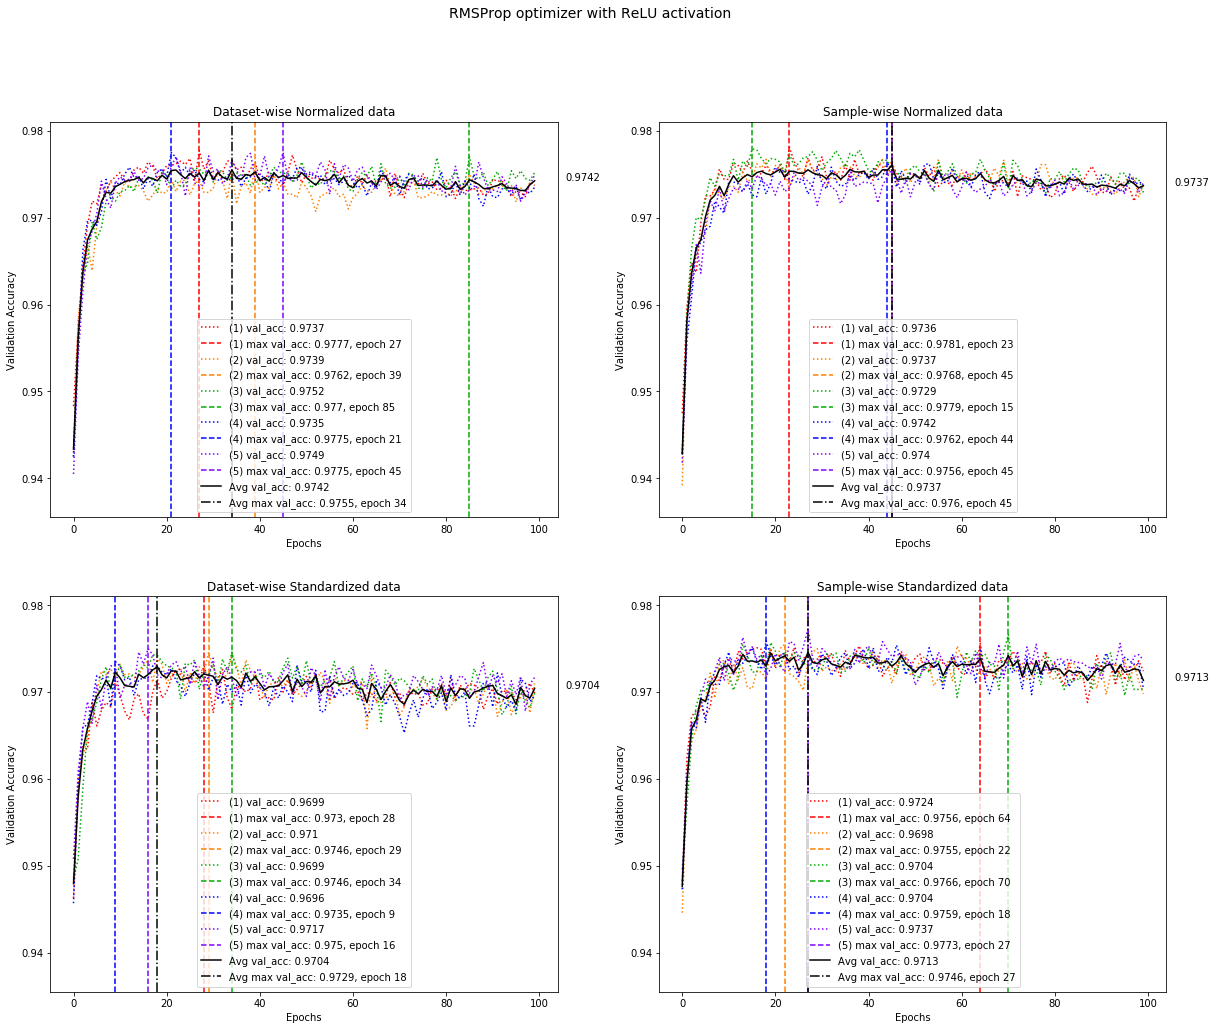

In [24]:
for d in range(len(data_normd)):

    
    plt.figure(figsize=(20,16))
    plt.suptitle('RMSProp optimizer with ReLU activation', fontsize=14)
    
    clr = 0
    plt.subplot(2,2,1)
    plt.title(data_normd[d]['name'])
    
    for i in range(experiments):
        plt.plot(range(epochs),
                 data_normd[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_normd[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_normd[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_normd[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_normd[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_normd[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_normd[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_normd[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_normd[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_normd[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_normd[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=1)
    plt.ylim(min([min(data_normd[d]['data'][i]['val_acc'].tolist()), 
                  min(data_normd_sw[d]['data'][i]['val_acc'].tolist()), 
                  min(data_std[d]['data'][i]['val_acc'].tolist()),
                  min(data_std_sw[d]['data'][i]['val_acc'].tolist())]) - 0.005, 
             max([data_normd[d]['max_val_acc']['avg']['val_acc'],
                  data_normd_sw[d]['max_val_acc']['avg']['val_acc'],
                  data_std[d]['max_val_acc']['avg']['val_acc'],
                  data_std_sw[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')

    clr = 0
    plt.subplot(2,2,2)
    plt.title(data_normd_sw[d]['name'])
    
    for i in range(experiments):
        plt.plot(range(epochs),
                 data_normd_sw[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_normd_sw[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_normd_sw[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_normd_sw[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_normd_sw[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_normd_sw[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_normd_sw[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_normd_sw[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_normd_sw[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_normd_sw[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_normd_sw[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_normd_sw[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=1)
    plt.ylim(min([min(data_normd[d]['data'][i]['val_acc'].tolist()), 
                  min(data_normd_sw[d]['data'][i]['val_acc'].tolist()), 
                  min(data_std[d]['data'][i]['val_acc'].tolist()),
                  min(data_std_sw[d]['data'][i]['val_acc'].tolist())]) - 0.005, 
             max([data_normd[d]['max_val_acc']['avg']['val_acc'],
                  data_normd_sw[d]['max_val_acc']['avg']['val_acc'],
                  data_std[d]['max_val_acc']['avg']['val_acc'],
                  data_std_sw[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')    
    
    clr = 0
    plt.subplot(2,2,3)
    plt.title(data_std[d]['name'])

    for i in range(experiments):
        plt.plot(range(epochs),
                 data_std[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_std[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_std[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_std[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_std[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_std[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_std[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_std[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_std[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_std[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_std[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=1)
    plt.ylim(min([min(data_normd[d]['data'][i]['val_acc'].tolist()), 
                  min(data_normd_sw[d]['data'][i]['val_acc'].tolist()), 
                  min(data_std[d]['data'][i]['val_acc'].tolist()),
                  min(data_std_sw[d]['data'][i]['val_acc'].tolist())]) - 0.005, 
             max([data_normd[d]['max_val_acc']['avg']['val_acc'],
                  data_normd_sw[d]['max_val_acc']['avg']['val_acc'],
                  data_std[d]['max_val_acc']['avg']['val_acc'],
                  data_std_sw[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')

    clr = 0
    plt.subplot(2,2,4)
    plt.title(data_std_sw[d]['name'])

    for i in range(experiments):
        plt.plot(range(epochs),
                 data_std_sw[d]['data'][i]['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle=':',
                 label='(' + str(i+1) + ') val_acc: ' + str(round(data_std_sw[d]['data'][i]['val_acc'].tolist()[-1], 4)))
        plt.axvline(x=data_std_sw[d]['max_val_acc'][i]['epoch'], 
                    label='(' + str(i+1) + ') max val_acc: ' + str(round(data_std_sw[d]['max_val_acc'][i]['val_acc'], 4)) + ', epoch ' + str(data_std_sw[d]['max_val_acc'][i]['epoch']),
                   color = colors_new[clr],
                   linestyle='--')
        clr += 1
        if clr > len(colors_new):
            clr = clr % len(colors_new)
    plt.plot(range(epochs),
                 data_std_sw[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Avg val_acc: ' + str(round(data_std_sw[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_std_sw[d]['max_val_acc']['avg']['epoch'], 
                label='Avg max val_acc: ' + str(round(data_std_sw[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_std_sw[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_std_sw[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_std_sw[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=1)
    plt.ylim(min([min(data_normd[d]['data'][i]['val_acc'].tolist()), 
                  min(data_normd_sw[d]['data'][i]['val_acc'].tolist()), 
                  min(data_std[d]['data'][i]['val_acc'].tolist()),
                  min(data_std_sw[d]['data'][i]['val_acc'].tolist())]) - 0.005, 
             max([data_normd[d]['max_val_acc']['avg']['val_acc'],
                  data_normd_sw[d]['max_val_acc']['avg']['val_acc'],
                  data_std[d]['max_val_acc']['avg']['val_acc'],
                  data_std_sw[d]['max_val_acc']['avg']['val_acc']]) + 0.005)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')

    plt.show()
    
    

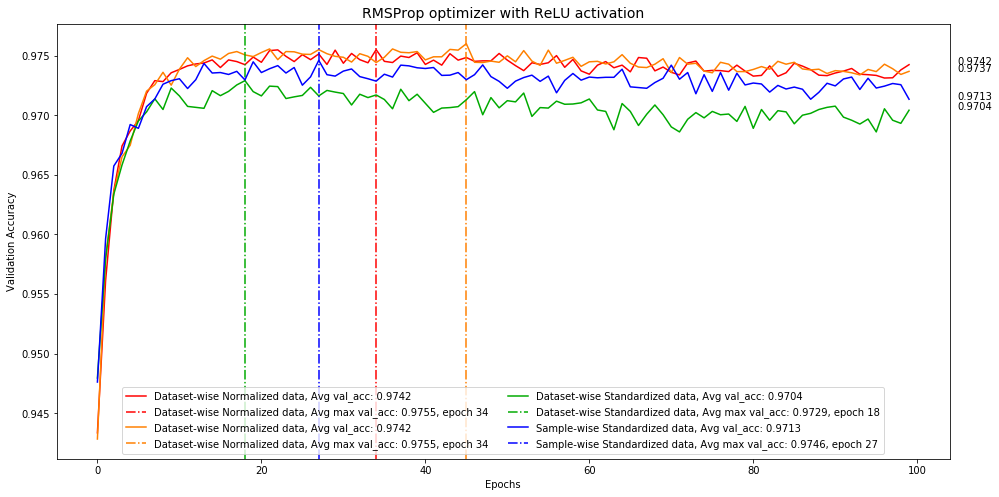

In [25]:
for d in range(len(data_normd)):

    clr = 0
    plt.figure(figsize=(16,8))
    plt.title('RMSProp optimizer with ReLU activation', fontsize=14)
    plt.plot(range(epochs),
                 data_normd[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Dataset-wise Normalized data, Avg val_acc: ' + str(round(data_normd[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_normd[d]['max_val_acc']['avg']['epoch'], 
                label='Dataset-wise Normalized data, Avg max val_acc: ' + str(round(data_normd[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_normd[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_normd[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_normd[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    
    clr+=1
    plt.plot(range(epochs),
                 data_normd_sw[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Dataset-wise Normalized data, Avg val_acc: ' + str(round(data_normd[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_normd_sw[d]['max_val_acc']['avg']['epoch'], 
                label='Dataset-wise Normalized data, Avg max val_acc: ' + str(round(data_normd[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_normd[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_normd_sw[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_normd_sw[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    
    clr+=1
    plt.plot(range(epochs),
                 data_std[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Dataset-wise Standardized data, Avg val_acc: ' + str(round(data_std[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_std[d]['max_val_acc']['avg']['epoch'], 
                label='Dataset-wise Standardized data, Avg max val_acc: ' + str(round(data_std[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_std[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_std[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_std[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    
    clr+=1
    plt.plot(range(epochs),
                 data_std_sw[d]['averaged']['val_acc'].tolist(),
                 colors_new[clr],
                 linestyle='-',
                 label='Sample-wise Standardized data, Avg val_acc: ' + str(round(data_std_sw[d]['averaged']['val_acc'].tolist()[-1], 4)))
    plt.axvline(x=data_std_sw[d]['max_val_acc']['avg']['epoch'], 
                label='Sample-wise Standardized data, Avg max val_acc: ' + str(round(data_std_sw[d]['max_val_acc']['avg']['val_acc'], 4)) + ', epoch ' + str(data_std_sw[d]['max_val_acc']['avg']['epoch']),
                color = colors_new[clr],                   
                linestyle='-.')
    
    plt.annotate('%0.4f' % data_std_sw[d]['averaged']['val_acc'].tolist()[-1], 
                 xy=(1, data_std_sw[d]['averaged']['val_acc'].tolist()[-1]), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.legend(loc='lower center',ncol=2)
    
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
#     plt.yscale('log')

    plt.show()
    
    